In [1]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from skimage.filters import threshold_li
from gasp import ssfp, phantom, tissue, responses, gasp as GASP

In [12]:
# Experiment parameters
T1, T2 = 1.2, .035
TR, alpha = 5e-3, np.deg2rad(30)
TE = TR / 2.0
BetaMax = 2 * np.pi
beta = np.linspace(-BetaMax, BetaMax, 100)
f = beta / TR / (2 * np.pi)
npcs = 16
pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)

In [13]:
img = phantom.phantom_generator(type='circle')
t = tissue.tissue_generator(type='circle')
mask = t['mask']
size = mask.shape
t1 = t['t1']
t2 = t['t2']
BetaMax = 4 * np.pi
beta = np.linspace(-BetaMax, BetaMax, size[1])
f = beta / TR / (2 * np.pi)
f = np.tile(f, (size[0], 1))
M = ssfp.ssfp(t1, t2, TR, TE, alpha, pcs, field_map=f, M0 = mask)
#M = ssfp.add_noise(M, sigma=0.01)
print(M.shape)

(256, 256, 16)


In [14]:
mask.shape

(256, 256)

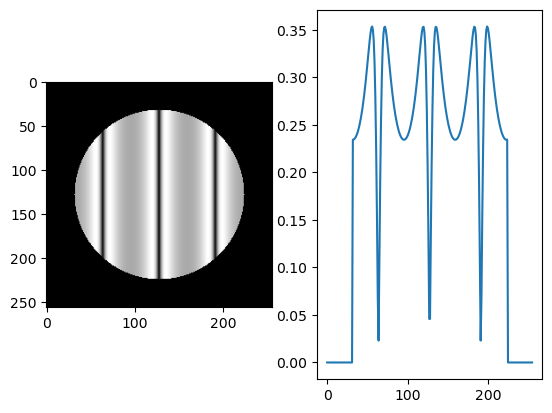

In [15]:
plt.imshow(abs(M[:,:,0]), cmap='gray')
_ = abs(M[:,:,0])
xx, yy = _.shape[:2]
plt.subplot(1, 2, 1)
plt.imshow(_, cmap='gray')
plt.subplot(1, 2, 2)
plt.plot(_[int(xx/2), :])
plt.show()

In [16]:
width = 256
height = 256
TRs = [5e-3, 10e-3, 15e-3]
nTRs = len(TRs)
M = np.empty((height, width, npcs,  nTRs), dtype=np.complex128)

for ii, TR in enumerate(TRs):
    TE = TR / 2.0
    M[..., ii] = ssfp.ssfp(t1, t2, TR, TE, alpha, pcs, field_map=f, M0 = mask)

M = np.reshape(M, (height, width, 1, npcs,  nTRs))
M.shape

(256, 256, 1, 16, 3)

(256, 256)
(256, 256, 1, 16, 3)


C:\Users\mmend\.conda\envs\mri\lib\site-packages\skimage\filters\thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))


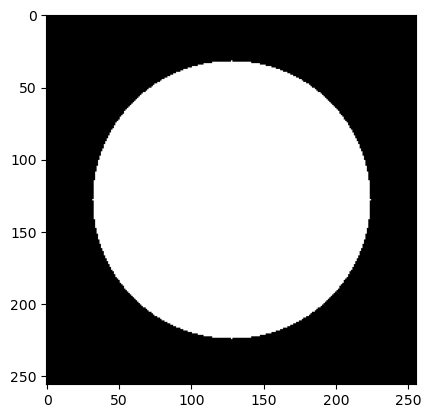

In [17]:
# Create mask of phantom
_ = np.sqrt(np.sum(np.abs(M)**2, axis=2))
_ = np.mean(_, axis=2)
_ = np.mean(_, axis=2)
_ = abs(_)
thresh = threshold_li(_)
mask = np.abs(_) > thresh
print(mask.shape)

# Apply mask to data
mask0 = np.tile(
    mask, (M.shape[2:] + (1, 1,))).transpose((3, 4, 0, 1, 2))
data = M * mask0
print(data.shape)
plt.imshow(abs(mask[:,:])*1, cmap='gray')
plt.show()

In [18]:
data = np.reshape(data, data.shape[:-2] + (-1,))    # [Height, Width, Coil, PCs x TRs]
data = np.moveaxis(data, 2, 0)                      # [Coil, Height, Width, PCs x TRs]
data = data.transpose((0, 3, 1, 2))                 # [Coil,  PCs x TRs, Width,   Height]
print(data.shape)

# Get new dimensions
ncoils, npcs, height, width = data.shape[:]

# Calibration box - (# Number of lines of calibration, Pixels on signal)
C_dim = (32, width)

(1, 48, 256, 256)


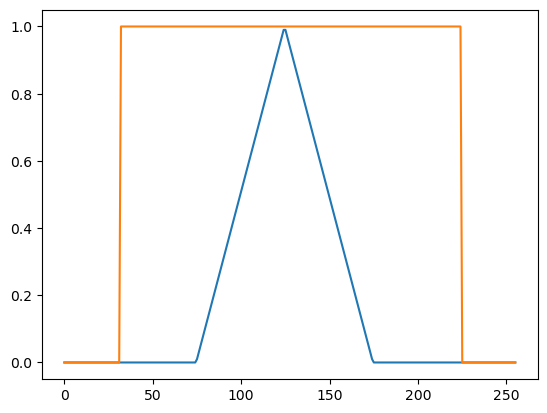

In [83]:
# Create forcing function
#D = responses.triangle_periodic(width, 120, 110, 38)
D = responses.triangle_periodic(width, 150, 75, 100)
#D = responses.triangle_periodic(width, 120, 50, 38)
D *= mask.T[int(height/2), :]
plt.plot(D)
plt.plot(mask[:, int(width/2)])
plt.show()

In [84]:
Ic = np.zeros((ncoils, height, width), dtype='complex')
for cc in range(ncoils):
    Ic[cc, ...] = GASP.gasp(data[cc, ...], D, C_dim, pc_dim=0)
Ic = np.sqrt(np.sum(np.abs(Ic)**2, axis=0))

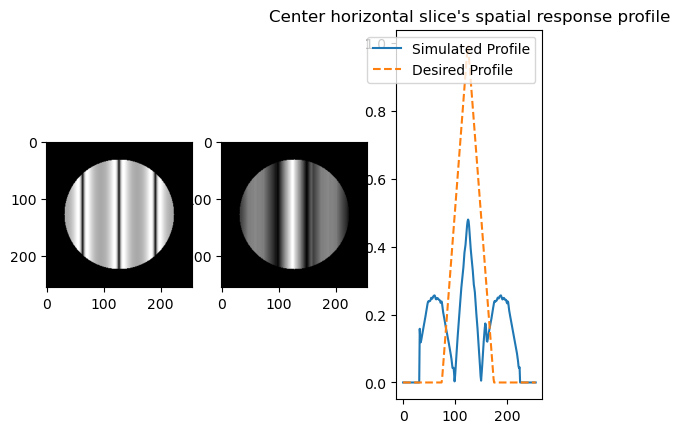

In [85]:
plt.subplot(1, 3, 1)
plt.imshow(np.sqrt(np.sum(abs(data[:, 0, ...])**2, axis=0)), cmap='gray')

plt.subplot(1, 3, 2)
plt.imshow(Ic, cmap='gray')

plt.subplot(1, 3, 3)
plt.plot(np.abs(Ic[int(height/2), :]), label='Simulated Profile')
plt.plot(D, '--', label='Desired Profile')
plt.legend()
plt.title('Center horizontal slice\'s spatial response profile')
plt.show()
